In [1]:
from sklearn.manifold import TSNE
import os
import numpy as np
from data_preprocessing import load_sst, load_IMDB
import gensim.downloader as api
import random
from keras.preprocessing.text import text_to_word_sequence
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to C:\Users\Chihao
[nltk_data]     Shen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_data, train_labels, test_data, test_labels, dev_data, dev_labels = load_sst()
dev_data_p = [data for data, label in zip(dev_data, dev_labels) if label == 1]
dev_data_n = [data for data, label in zip(dev_data, dev_labels) if label == 0]
df = load_IMDB()
df_p = df[df['sentiment'] == 1]
df_n = df[df['sentiment'] == 0]

INFO: SST-2 loaded
e:\git\SC4001\Project\data_preprocessing.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sentiment'] = df['sentiment'].replace({'positive': 1, 'negative': 0})


In [3]:
model_type = 'word2vec-google-news-300'
w2vModel = api.load(model_type)
words = list(w2vModel.key_to_index.keys())
print(train_data[0])

INFO: loading projection weights from C:\Users\Chihao Shen/gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz
INFO: KeyedVectors lifecycle event {'msg': 'loaded (3000000, 300) matrix of type float32 from C:\\Users\\Chihao Shen/gensim-data\\word2vec-google-news-300\\word2vec-google-news-300.gz', 'binary': True, 'encoding': 'utf8', 'datetime': '2024-04-14T04:15:38.887993', 'gensim': '4.3.2', 'python': '3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'load_word2vec_format'}


hide new secretions from the parental units 


In [4]:
random.seed(42)
sst2_p = random.sample(dev_data_p, 200)
imdb_p = df_p.sample(200, random_state=42)['review'].tolist()
sst2_n = random.sample(dev_data_n, 200)
imdb_n = df_n.sample(200, random_state=42)['review'].tolist()


def vectorize(sentences, model, dimension, wv_type='zero_padding'):
    tokens = [text_to_word_sequence(s.lower()) for s in sentences]
    wvs = []
    for t in tokens:
        wv = []
        for w in t:
            if wv_type == 'zero_padding':
                try:
                    wv.append(model[w])
                except KeyError:
                    wv.append(np.zeros(dimension))
        wvs.append(wv)

    return wvs
sst2_p = vectorize(sst2_p, w2vModel, 300)
imdb_p = vectorize(imdb_p, w2vModel, 300)
sst2_n = vectorize(sst2_n, w2vModel, 300)
imdb_n = vectorize(imdb_n, w2vModel, 300)

In [5]:
max_length = max([len(i) for i in sst2_p])  # 
print(max_length)
def to_tensor(X, max_length):
    wv_num = X[0][0].shape[0]
    X_list = []
    for i in X:
        temp = i
        if len(i) > max_length:
            temp = temp[:max_length]
        for _ in range(max_length - len(i)):
            temp.append(np.zeros(wv_num))
        np_array = np.array(temp)
        X_list.append(np_array)
    X_tensor = np.stack(X_list)
    return X_tensor
sst_p_tensor = to_tensor(sst2_p, max_length)
imdb_p_tensor = to_tensor(imdb_p, max_length)
sst_n_tensor = to_tensor(sst2_n, max_length)
imdb_n_tensor = to_tensor(imdb_n, max_length)

42


In [6]:

sst_p_tensor.shape

(200, 42, 300)

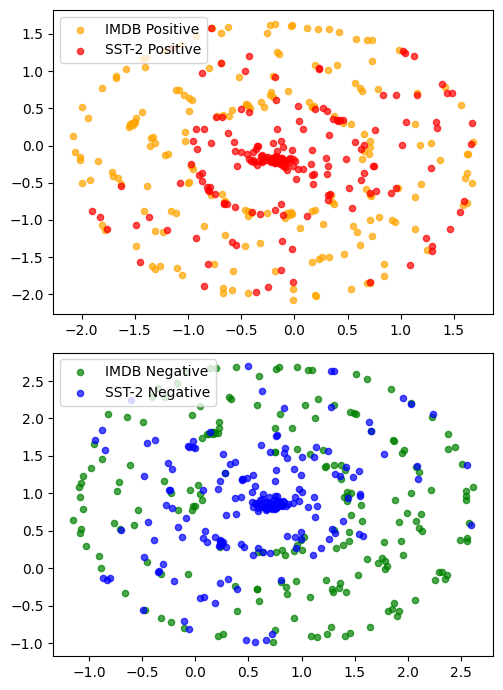

In [7]:
concatenated_data_p = np.concatenate([sst_p_tensor.reshape(200, -1), imdb_p_tensor.reshape(200, -1)], axis=0)
concatenated_data_n = np.concatenate([sst_n_tensor.reshape(200, -1), imdb_n_tensor.reshape(200, -1)], axis=0)
tsne_p = TSNE(n_components=2, random_state=42)
tsne_n = TSNE(n_components=2, random_state=42)
tsne_result_p = tsne_p.fit_transform(concatenated_data_p)
tsne_result_n = tsne_n.fit_transform(concatenated_data_n)
tsne_result_p1 = tsne_result_p[:200]
tsne_result_p2 = tsne_result_p[200:]
tsne_result_n1 = tsne_result_n[:200]
tsne_result_n2 = tsne_result_n[200:]

# plot the results
plt.figure(figsize=(5, 7))
plt.subplot(2, 1, 1) 
plt.scatter(tsne_result_p2[:, 0], tsne_result_p2[:, 1], color='orange', label='IMDB Positive', alpha=0.7, s=20)
plt.scatter(tsne_result_p1[:, 0], tsne_result_p1[:, 1], color='red', label='SST-2 Positive', alpha=0.7, s=20)
plt.legend()

plt.subplot(2, 1, 2) 
plt.scatter(tsne_result_n2[:, 0], tsne_result_n2[:, 1], color='green', label='IMDB Negative', alpha=0.7, s=20)
plt.scatter(tsne_result_n1[:, 0], tsne_result_n1[:, 1], color='blue', label='SST-2 Negative', alpha=0.7, s=20)
plt.legend()
os.makedirs("./image", exist_ok=True)
plt.savefig('./image/t-SNE.png')
plt.tight_layout()
plt.show()